In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

# Import TensorFlow Lite
from tensorflow import lite

In [5]:
import pandas as pd

df = pd.read_csv('./input/train.csv')

diagnosis_dict_binary = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] = df['diagnosis'].map(diagnosis_dict_binary)
df['type'] = df['diagnosis'].map(diagnosis_dict)
df.head()

id_code  diagnosis  binary_type            type
0  000c1434d8d7          2            1        Moderate
1  001639a390f0          4            1  Proliferate_DR
2  0024cdab0c1e          1            1            Mild
3  002c21358ce6          0            0           No_DR
4  005b95c28852          0            0           No_DR

<Axes: ylabel='type'>

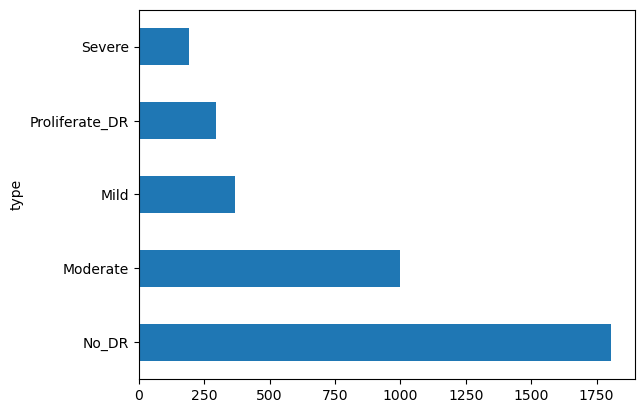

In [6]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

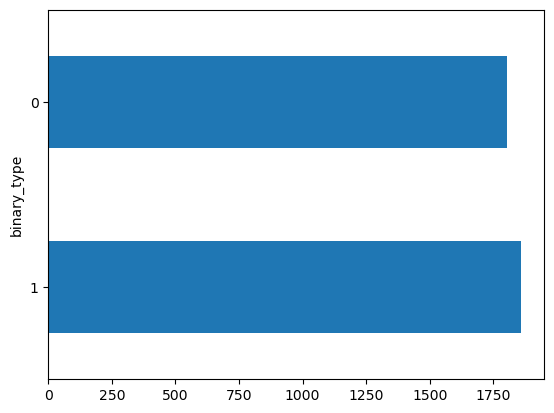

In [7]:
df['binary_type'].value_counts().plot(kind='barh')

In [8]:
import os
import pandas as pd

sdir = './input/gfi'
classlist = os.listdir(sdir)

filepaths = []
labels = []

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print('df length:', len(df))
print(df['labels'].value_counts())

                           filepaths labels
0  ./input/gfi\Mild\0024cdab0c1e.png   Mild
1  ./input/gfi\Mild\00cb6555d108.png   Mild
2  ./input/gfi\Mild\0124dffecf29.png   Mild
3  ./input/gfi\Mild\01b3aed3ed4c.png   Mild
4  ./input/gfi\Mild\0369f3efe69b.png   Mild
df length: 3662
labels
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


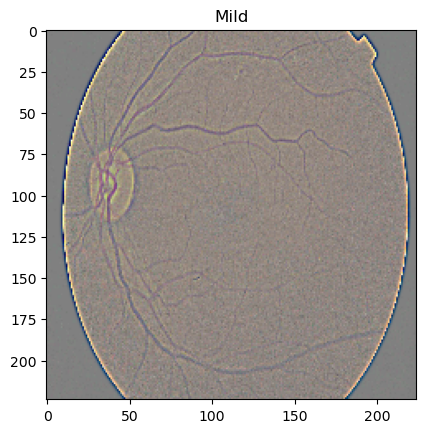

In [9]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread("./input/gfi/Mild/00cb6555d108.png")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Mild")
plt.show()

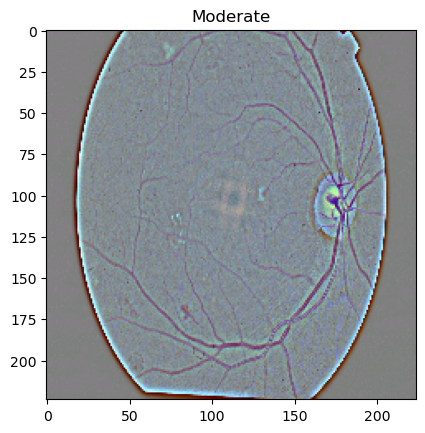

In [10]:
img1 = cv2.imread("./input/gfi/Moderate/0161338f53cc.png")
plt.imshow(img1)
plt.title("Moderate")
plt.show()

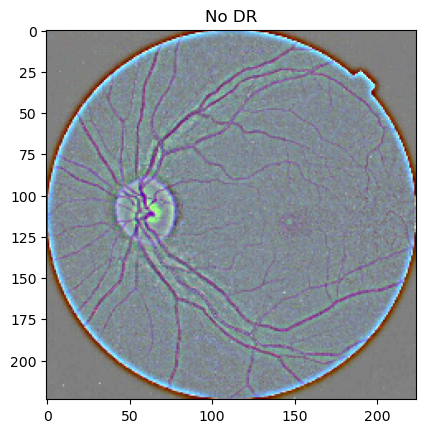

In [11]:
img1 = cv2.imread("./input/gfi/No_DR/00cc2b75cddd.png")
plt.imshow(img1)
plt.title("No DR")
plt.show()

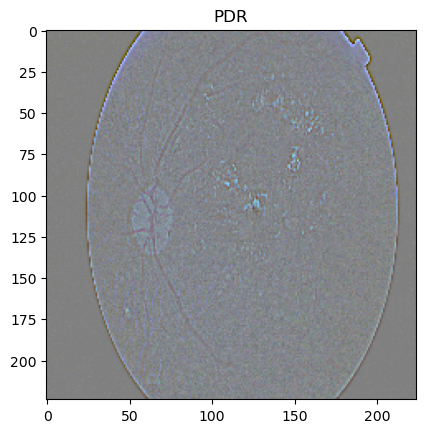

In [12]:
img1 = cv2.imread("./input/gfi/Proliferate_DR/034cb07a550f.png")
plt.imshow(img1)
plt.title("PDR")
plt.show()

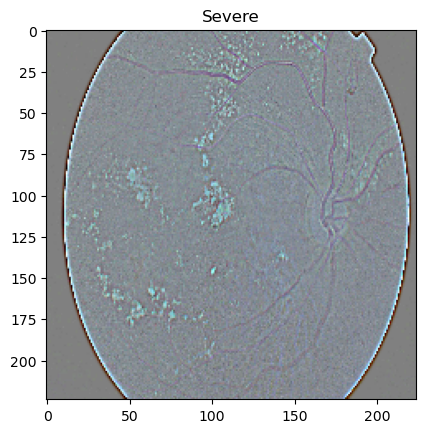

In [13]:
img1 = cv2.imread("./input/gfi/Severe/0c917c372572.png")
plt.imshow(img1)
plt.title("Severe")
plt.show()

In [14]:
sample_list = []
max_size = 1500

groups = df.groupby('labels')

for label in df['labels'].unique():
    group = groups.get_group(label)
    sample_count = len(group)
    
    if sample_count > max_size:
        samples = group.sample(max_size, replace=False, random_state=123)
    else:
        samples = group.sample(frac=1.0, replace=False, random_state=123)
    
    sample_list.append(samples)

df = pd.concat(sample_list, axis=0).reset_index(drop=True)

print(len(df))
print(df['labels'].value_counts())

3357
labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64


In [15]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [16]:
target=1500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 370 validated image filenames.
Found 999 validated image filenames.
Found 295 validated image filenames.
Found 193 validated image filenames.


In [17]:
aug=r'./aug'
auglist=os.listdir(aug)
print (auglist)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('class: ', klass, '  file count: ', len(flist))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
class:  Mild   file count:  1130
class:  Moderate   file count:  501
class:  No_DR   file count:  0
class:  Proliferate_DR   file count:  1205
class:  Severe   file count:  1307


In [18]:
target=1500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 370 validated image filenames.
Found 999 validated image filenames.
Found 295 validated image filenames.
Found 193 validated image filenames.


In [19]:
aug=r'./aug'
auglist=os.listdir(aug)
print (auglist)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('class: ', klass, '  file count: ', len(flist))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
class:  Mild   file count:  2260
class:  Moderate   file count:  1002
class:  No_DR   file count:  0
class:  Proliferate_DR   file count:  2410
class:  Severe   file count:  2614


In [20]:
aug=r'./aug'
auglist=os.listdir(aug)
print (auglist)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('class: ', klass, '  file count: ', len(flist))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
class:  Mild   file count:  2260
class:  Moderate   file count:  1002
class:  No_DR   file count:  0
class:  Proliferate_DR   file count:  2410
class:  Severe   file count:  2614


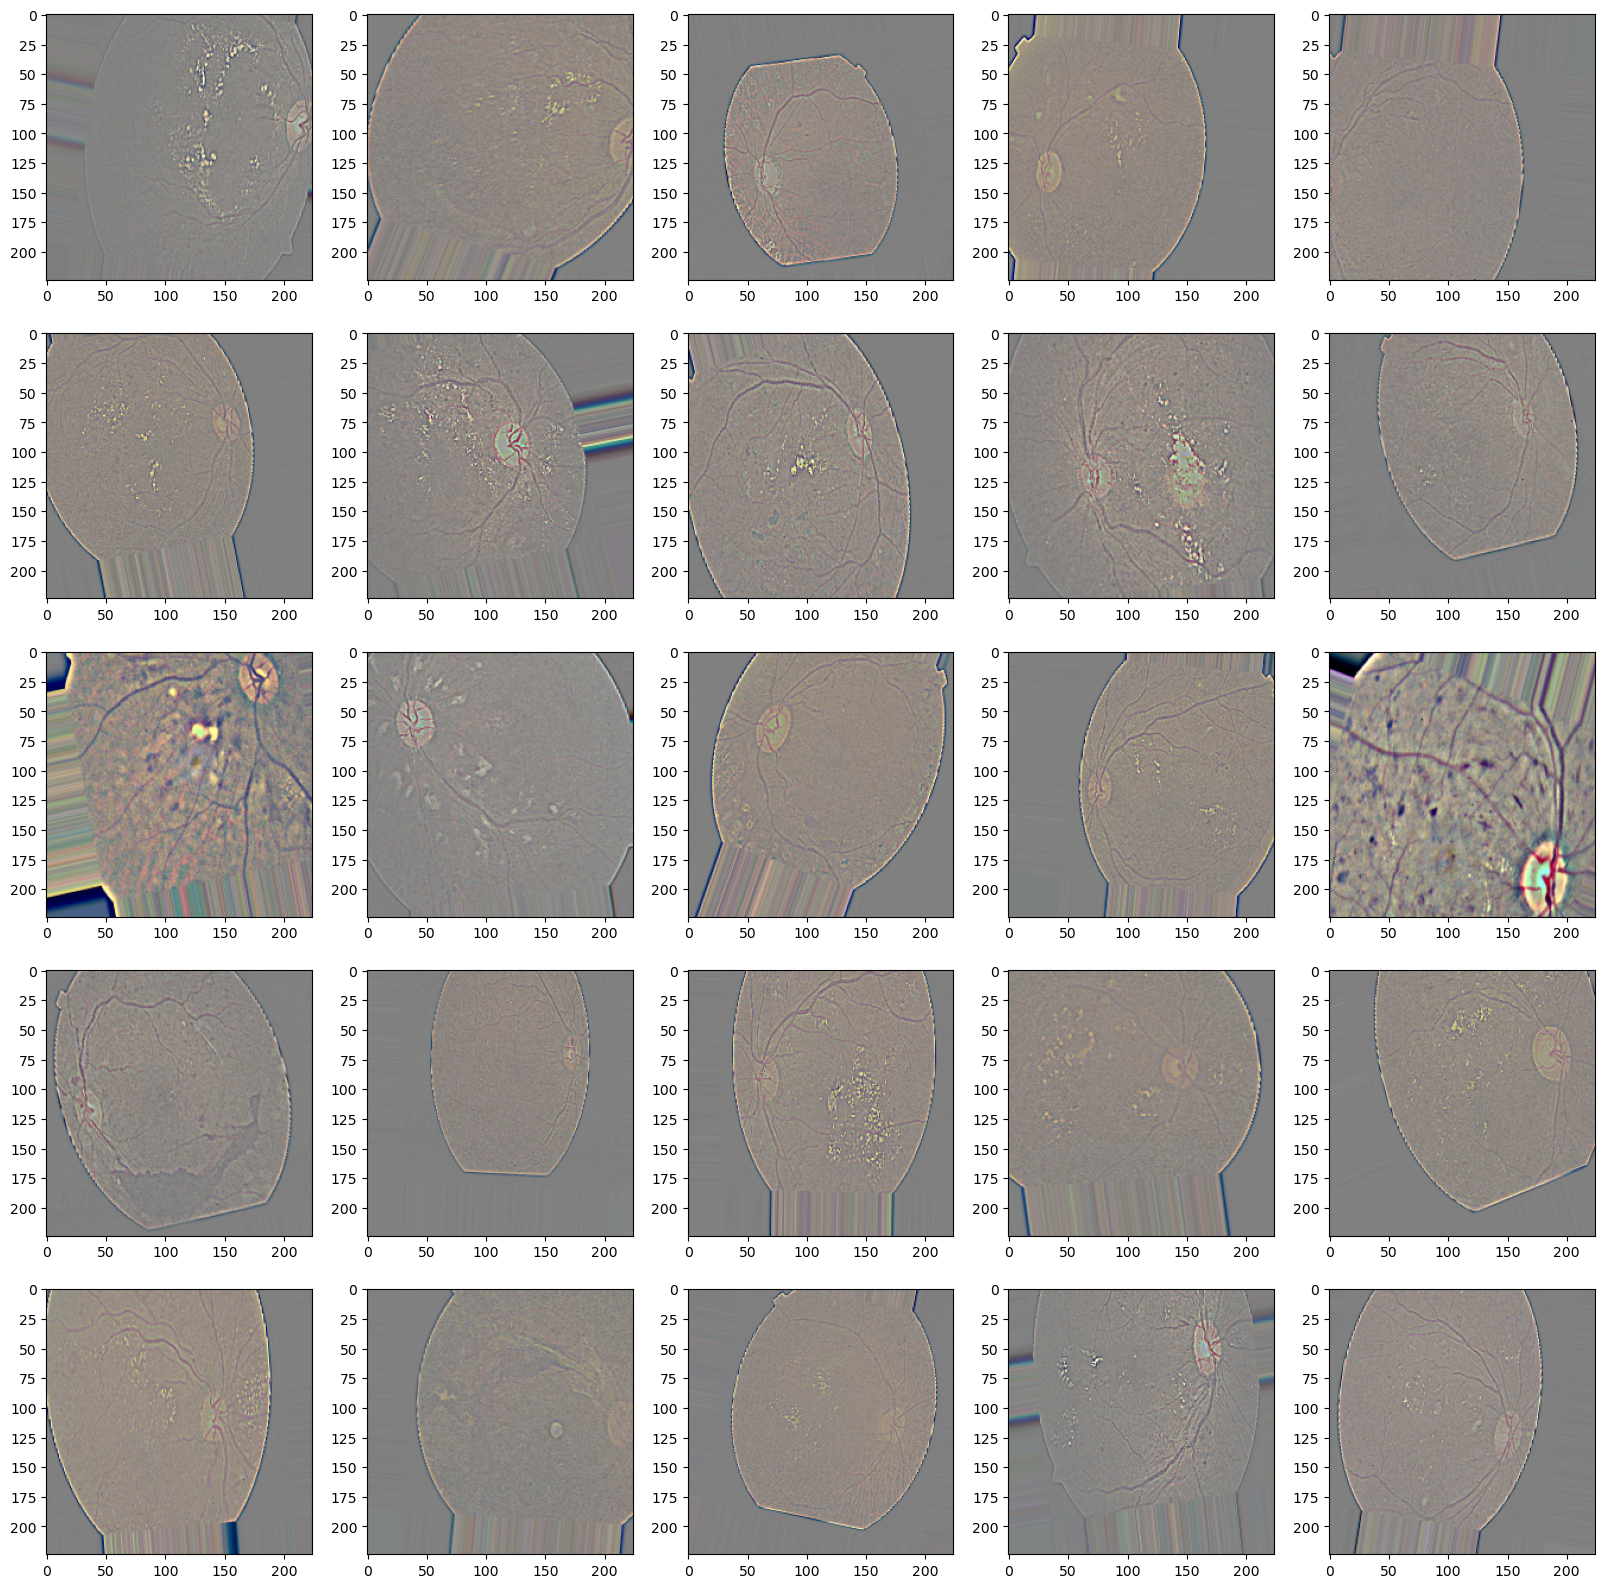

In [21]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image=next(aug_gen)/255
    image=np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()

In [22]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['labels'].value_counts()) 
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts()) 

labels
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64
labels
Severe            2639
Proliferate_DR    2410
Mild              2260
Moderate          1002
Name: count, dtype: int64
labels
Severe            2832
Proliferate_DR    2705
Mild              2630
Moderate          2001
No_DR             1500
Name: count, dtype: int64


In [23]:
train_split=.8
valid_split=.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  9334   test_df length:  1167   valid_df length:  1167


In [24]:
ndf.head()

filepaths labels
0  ./input/gfi\Mild\28f98cfe3858.png   Mild
1  ./input/gfi\Mild\a3d2a0c4cd17.png   Mild
2  ./input/gfi\Mild\0684311afdfc.png   Mild
3  ./input/gfi\Mild\c96f743915b5.png   Mild
4  ./input/gfi\Mild\c1e6fa1ad314.png   Mild

In [25]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  3   test steps:  389
Found 9334 validated image filenames belonging to 5 classes.
Found 1167 validated image filenames belonging to 5 classes.
Found 1167 validated image filenames belonging to 5 classes.


In [26]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

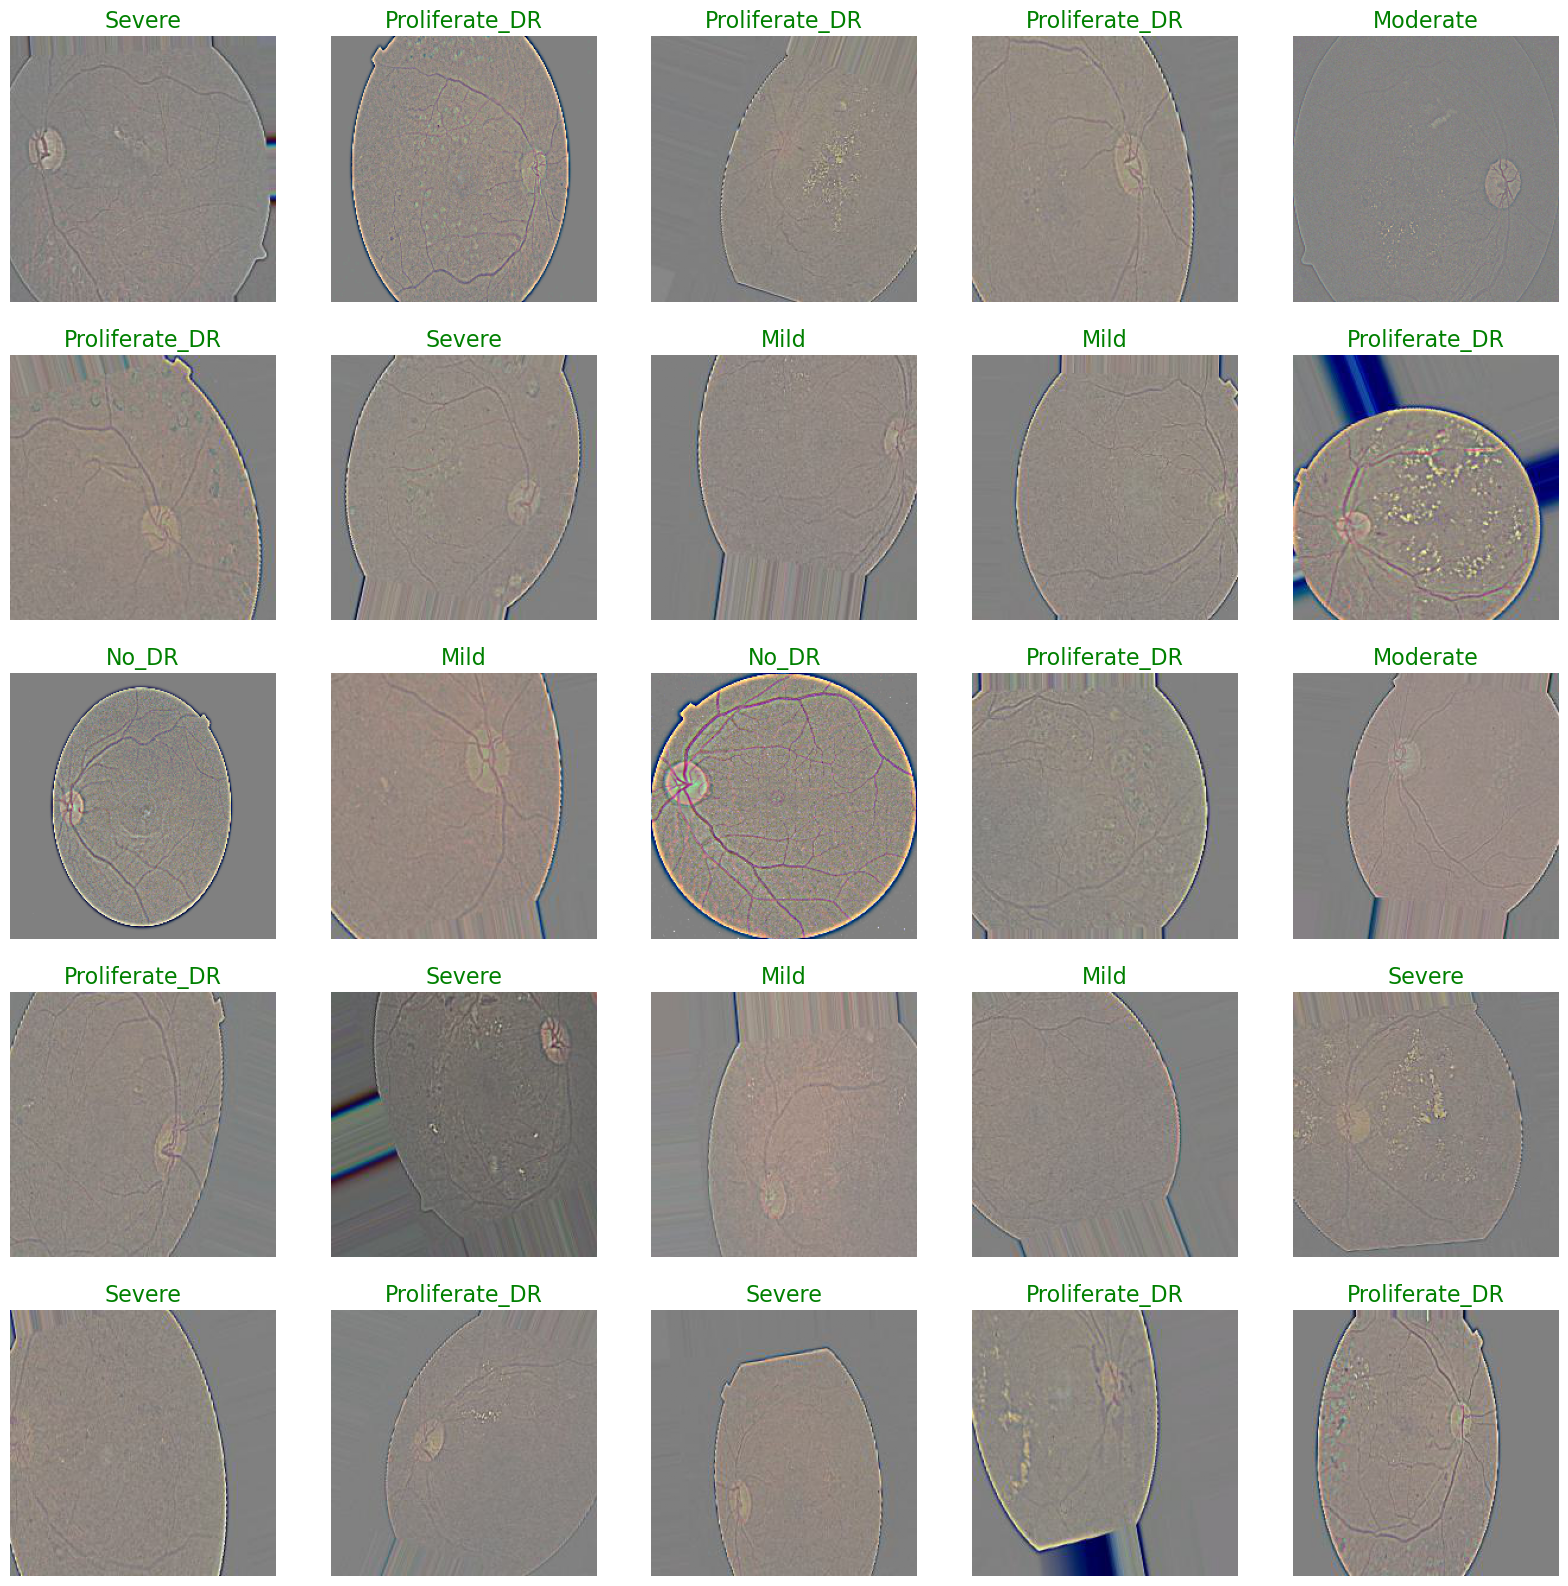

In [27]:
show_image_samples(train_gen)

In [28]:
import keras  # Import the keras module

class LRA(keras.callbacks.Callback):
    # ... rest of your code as it is

    class LRA(keras.callbacks.Callback):
        reset=False
        count=0
        stop_count=0

        def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
            super(LRA, self).__init__()
            self.epochs=epochs
            self.ask_epoch=ask_epoch
            self.model=model
            self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
            self.stop_patience=stop_patience
            self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
            self.factor=factor # factor by which to reduce the learning rate
            self.dwell=dwell
            self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
            self.highest_tracc=0.0 # set highest training accuracy to 0
            self.lowest_vloss=np.inf # set lowest validation loss to infinity
            #self.count=0 # initialize counter that counts epochs with no improvement
            #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
            self.initial_epoch=initial_epoch 
            self.batches=batches
            #self.epochs=epochs
            best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
            msg=' '
            if freeze==True:
                msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
            else:
                msgs=f' Starting training using base model { model_name} training all layers '            
            print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        def on_train_begin(self, logs=None):
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                                  'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
        def on_train_end(self, logs=None):
            model.set_weights(LRA.best_weights)
            msg='Training is completed - model is set with weights for the epoch with the lowest loss'
            print_in_color(msg, (0,255,0), (55,65,80)) 

        def on_train_batch_end(self, batch, logs=None):
            acc=logs.get('accuracy')* 100  # get training accuracy 
            loss=logs.get('loss')
            msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
            print(msg, '\r', end='') # prints over on the same line to show running batch count


        def on_epoch_begin(self,epoch, logs=None):
            self.now= time.time()

        def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
            later=time.time()
            duration=later-self.now 
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            current_lr=lr
            v_loss=logs.get('val_loss')  # get the validation loss for this epoch
            acc=logs.get('accuracy')  # get training accuracy 
            v_acc=logs.get('val_accuracy')
            loss=logs.get('loss')
            #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
            if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
                monitor='accuracy'
                if acc>self.highest_tracc: # training accuracy improved in the epoch                
                    self.highest_tracc=acc # set new highest training accuracy
                    LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                    self.count=0 # set count to 0 since training accuracy improved
                    self.stop_count=0 # set stop counter to 0
                    if v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss
                    color= (0,255,0)
                    self.lr=lr
                else: 
                    # training accuracy did not improve check if this has happened for patience number of epochs
                    # if so adjust learning rate
                    if self.count>=self.patience -1:
                        color=(245, 170, 66)
                        self.lr= lr* self.factor # adjust the learning by factor
                        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                        self.count=0 # reset the count to 0
                        self.stop_count=self.stop_count + 1
                        if self.dwell:
                            self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                        else:
                            if v_loss<self.lowest_vloss:
                                self.lowest_vloss=v_loss                                    
                    else:
                        self.count=self.count +1 # increment patience counter                    
            else: # training accuracy is above threshold so adjust learning rate based on validation loss
                monitor='val_loss'
                if v_loss< self.lowest_vloss: # check if the validation loss improved 
                    self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                    LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                    self.count=0 # reset count since validation loss improved  
                    self.stop_count=0  
                    color=(0,255,0)
                    self.lr=lr
                else: # validation loss did not improve
                    if self.count>=self.patience-1:
                        color=(245, 170, 66)
                        self.lr=self.lr * self.factor # adjust the learning rate                    
                        self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                        self.count=0 # reset counter
                        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                        if self.dwell:
                            self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else: 
                        self.count =self.count +1 # increment the patience counter                    
                    if acc>self.highest_tracc:
                        self.highest_tracc= acc
            msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
            print_in_color (msg,color, (55,65,80))
            if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
                msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
                print_in_color(msg, (0,255,255), (55,65,80))
                self.model.stop_training = True # stop training
            else: 
                if self.ask_epoch !=None:
                    if epoch + 1 >= self.ask_epoch:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        ans=input('')
                        if ans=='H' or ans=='h':
                            msg=f'training has been halted at epoch {epoch + 1} due to user input'
                            print_in_color(msg, (0,255,255), (55,65,80))
                            self.model.stop_training = True # stop training
                        else:
                            ans=int(ans)
                            self.ask_epoch +=ans



In [29]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18384\1572855052.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [31]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()



27018416/27018416 [==============================] - 7s 0us/step



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [32]:
class LRA(tf.keras.callbacks.Callback):
    def __init__(self, model, patience=1, stop_patience=3, threshold=0.9, factor=0.5, dwell=True, model_name='model', freeze=False, batches=1, initial_epoch=0, epochs=10, ask_epoch=10):
        super().__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.model_name = model_name
        self.freeze = freeze
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch

    def on_epoch_end(self, epoch, logs=None):
        # Your custom logic here
        pass

In [33]:
model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x=train_gen,
                    epochs=30,
                    validation_data=valid_gen)

Epoch 1/30



234/234 [==============================] - 221s 905ms/step - loss: 1.6736 - accuracy: 0.3580 - val_loss: 1.5160 - val_accuracy: 0.3128
Epoch 2/30
234/234 [==============================] - 143s 610ms/step - loss: 1.2913 - accuracy: 0.3649 - val_loss: 1.3589 - val_accuracy: 0.3762
Epoch 3/30
234/234 [==============================] - 124s 529ms/step - loss: 1.2647 - accuracy: 0.4010 - val_loss: 1.1716 - val_accuracy: 0.4901
Epoch 4/30
234/234 [==============================] - 120s 514ms/step - loss: 1.2192 - accuracy: 0.4368 - val_loss: 1.5987 - val_accuracy: 0.3256
Epoch 5/30
234/234 [==============================] - 117s 499ms/step - loss: 1.2014 - accuracy: 0.4459 - val_loss: 1.3681 - val_accuracy: 0.3625
Epoch 6/30
234/234 [==============================] - 120s 511ms/step - loss: 1.1696 - accuracy: 0.4592 - val_loss: 1.1705 - val_accuracy: 0.4893
Epoch 7/30
234/234 [==============================] - 122s 519ms/step - loss: 1.1790 - accuracy: 0.4641 - val_loss: 1.2660 - val_accura

In [34]:
model.save('efficientnetb1.h5')

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


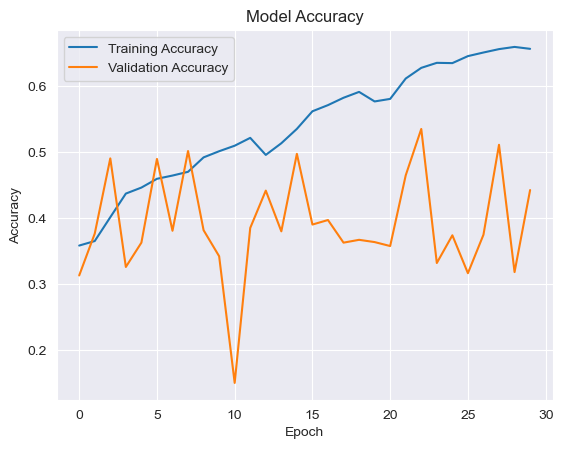

In [35]:
def display_accuracy(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()

# Call the function with the history object
display_accuracy(history)

In [36]:
pred = model.predict(test_gen)

389/389 [==============================] - 12s 30ms/step


In [37]:
pred

array([[9.9059653e-01, 3.7842789e-03, 3.7315560e-05, 5.5713905e-03,
        1.0503568e-05],
       [3.7284697e-06, 3.0614836e-03, 9.9693477e-01, 3.6917840e-18,
        6.1318908e-25],
       [6.9524482e-02, 5.8562249e-01, 1.3011474e-04, 2.8993529e-01,
        5.4787647e-02],
       ...,
       [3.4036580e-05, 9.2894034e-03, 9.9067652e-01, 3.3701575e-16,
        2.0122687e-22],
       [9.9980944e-01, 5.7370248e-06, 3.4835173e-09, 1.8478704e-04,
        2.3294673e-09],
       [3.7808895e-01, 5.3008670e-01, 8.6406976e-02, 5.1434580e-03,
        2.7395133e-04]], dtype=float32)

In [38]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

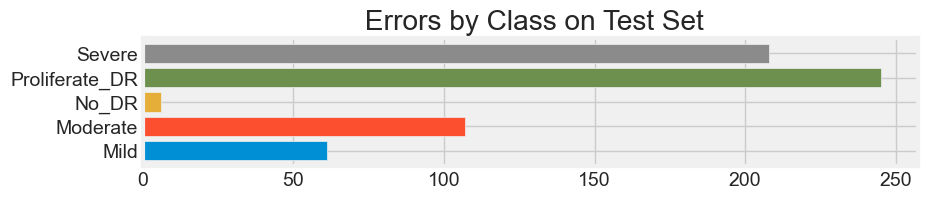

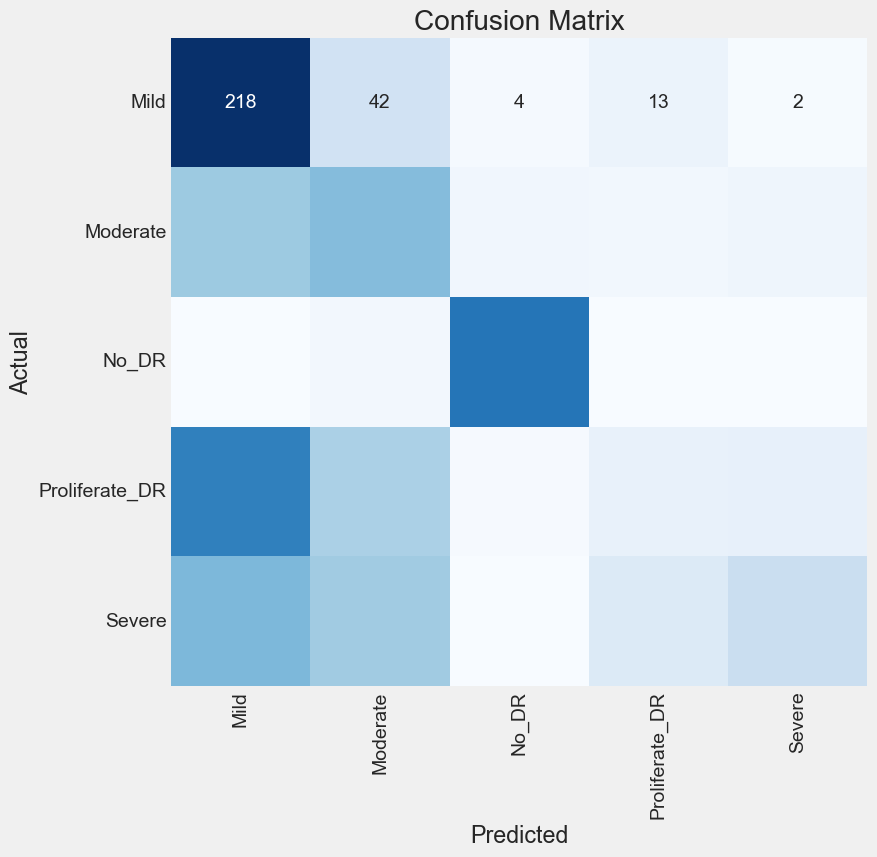

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.40      0.78      0.53       279
      Moderate       0.32      0.47      0.38       202
         No_DR       0.91      0.96      0.94       166
Proliferate_DR       0.26      0.06      0.10       262
        Severe       0.62      0.19      0.30       258

      accuracy                           0.46      1167
     macro avg       0.50      0.49      0.45      1167
  weighted avg       0.48      0.46      0.41      1167



In [39]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, pred, print_code, save_dir, subject )  